# FBP reconstruction of the agarose phantom


In [3]:
# Import relevant packages

from __future__ import division
from os import mkdir
from os.path import join, isdir
 
import astra
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

# Timing
from tqdm import tqdm
import time

# Garbage collection
import gc

import sys
sys.path.append('../')

 Phase contrast

Code starts here

Reconstruction of our image from 2D geometry

In [20]:
# Regular import
# del im
# del reconstruction_fbp
gc.collect()

import pickle
with open("2023-04-16 agarose-phantom-fourier-bgdivide-imag-addmin.pkl", 'rb') as f:
    im = pickle.load(f)

In [7]:
# with open("2023-04-10 agarose-phantom-fourier-firstproj.pkl", 'wb') as f:
#     pickle.dump(im[0], f)

In [22]:
# Crop image to centre the centre of the image on the rotation axis
# im has dimensions (projections, height, width)
# The crop is 12
im = im[:,::100,12:]
im.shape

(400, 14, 1028)

In [24]:
im.min(), im.max()

(-0.0, 153170.3671875)

In [25]:
# Turn into sinogram
im = np.moveaxis(im, 0, -2).astype('float64')
print(im.shape)

(14, 400, 1028)


Phase can be positive or negative. We do not rescale and do not limit our reconstructions but instead use floating point representation throughout.

In [8]:
def fbp(im):
    # Preallocate Memory
    reconstruction_fbp = np.zeros((im.shape[0], im.shape[2], im.shape[2]))

    # Infer parameters from inputs
    num_of_projections = im.shape[1]
    detector_rows = im.shape[0]  # Vertical size of detector [pixels].
    detector_cols = im.shape[-1]  # Horizontal size of detector [pixels].
    angles = np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False)

    start = time.time()
    for i in tqdm(range(im.shape[0])):
        # Copy projection images into ASTRA Toolbox.
        proj_geom = \
        astra.create_proj_geom('parallel', 1.0, detector_cols, angles)
        projections_id = astra.data2d.create('-sino', proj_geom, im[i])

        # Create reconstruction.
        vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols,
                                                detector_rows)
        reconstruction_id = astra.data2d.create('-vol', vol_geom, data=0)
        alg_cfg = astra.astra_dict('FBP_CUDA')
        alg_cfg['ProjectionDataId'] = projections_id
        alg_cfg['ReconstructionDataId'] = reconstruction_id
        algorithm_id = astra.algorithm.create(alg_cfg)
        astra.algorithm.run(algorithm_id)
        reconstruction = astra.data2d.get(reconstruction_id)
        
        # Save reconstruction to preallocated memory
        reconstruction_fbp[i] = reconstruction
        
        # Cleanup.
        astra.algorithm.delete(algorithm_id)
        astra.data2d.delete(reconstruction_id)
        astra.data2d.delete(projections_id)

    end = time.time()
    print(end-start)
    return reconstruction_fbp


In [ ]:
reconstruction_fbp = fbp(im)
#plt.imshow(reconstruction)

In [27]:
np.max(reconstruction_fbp)

442.9737243652344

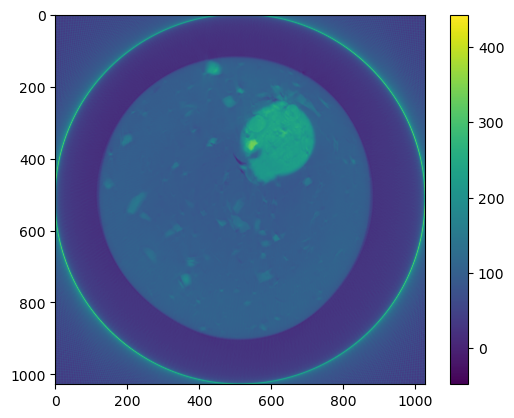

In [28]:
plt.imshow(reconstruction_fbp[-1], vmin=np.min(reconstruction_fbp), vmax=np.max(reconstruction_fbp))
plt.colorbar()

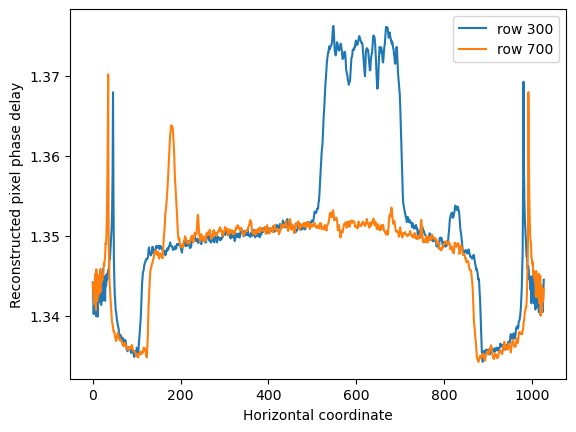

In [37]:

plt.plot(reconstruction_fbp[10, 300]/(6.45 *1040) + 1.333, label='row 300')
plt.plot(reconstruction_fbp[10, 700]/(6.45 *1040) + 1.333, label='row 700')
plt.ylabel('Reconstructed pixel phase delay')
plt.xlabel('Horizontal coordinate')
plt.legend()

In [15]:
# with open("2023-04-10 agarose-phantom-fourier-14slices.pkl", 'wb') as f:
#     pickle.dump(reconstruction_fbp, f)

Now do the same with the brightfield images

In [15]:
# filepath on Predator machine
img_dir = r'D:\MSci_Project\1_Data\2023-03-17'
phantom = io.imread(img_dir + r'\2023-03-17 phase gradient phantom fullstack.tif')
phantom = phantom.reshape((400,4,1392,1040)).astype('float32')

# background
background = io.imread(img_dir + r'\2023-03-17 phase gradient background.tif').astype('float32')[0:]

def get_averaged_stack(im_stack, num_repeats):
    # Gets averaged image stack, assuming shape of image stack is (num_repeats * z_stack_depth, im_height, im_width)
    # num_repeats (int): number of averaged images
    # SIMILAR TO calibrations/lens_aperture.ipynb, but order is reversed
    num_repeats = int(num_repeats)

    dim_0, im_length, im_width = im_stack.shape
    reshaped = im_stack.reshape(num_repeats, dim_0//num_repeats, im_length, im_width)
    output = np.mean(reshaped, axis=0)
    return output

background = get_averaged_stack(background, 5)

phantom/= background

In [16]:
brightfield_lr = np.sum(phantom[:,0:2,:,:], axis=(1))
# brightfield_tb = np.sum(phantom[:,0:2,:,:], axis=(1))
del phantom

Text(0.5, 1.0, 'top-bottom')

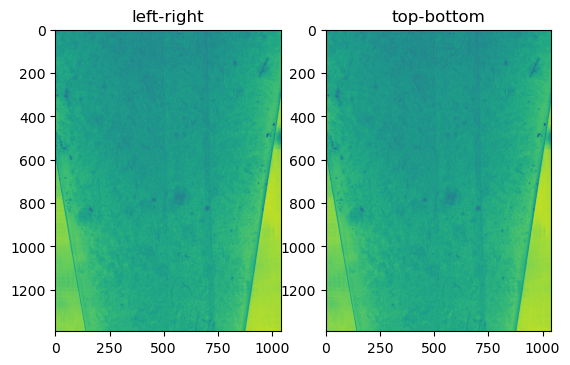

In [6]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(brightfield_lr[0])
ax[1].imshow(brightfield_tb[0])
ax[0].set_title('left-right')
ax[1].set_title('top-bottom')

In [17]:
im = brightfield_lr[:,::100,12:]
im = np.moveaxis(im, 0, -2).astype('float64')
brightfield_reconstruct = fbp(im)

100%|██████████| 14/14 [00:00<00:00, 29.03it/s]

0.49146246910095215


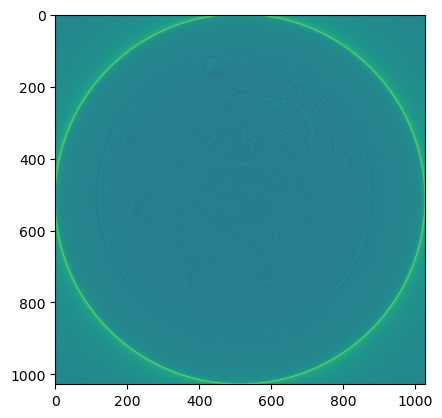

In [22]:
plt.imshow(brightfield_reconstruct[-1], vmin=np.min(brightfield_reconstruct), vmax=np.max(brightfield_reconstruct))
plt.show()

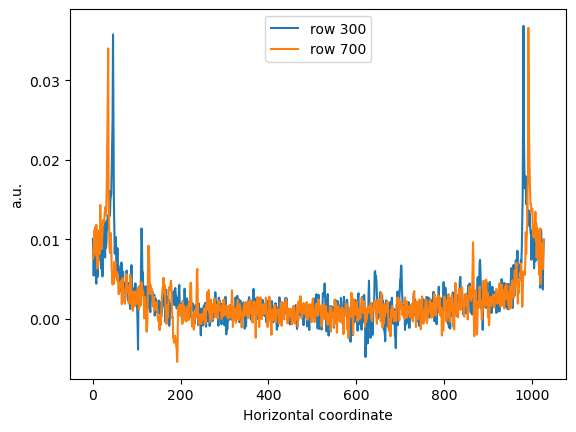

In [23]:
plt.plot(brightfield_reconstruct[10, 300], label='row 300')
plt.plot(brightfield_reconstruct[10, 700], label='row 700')
plt.ylabel('a.u.')
plt.xlabel('Horizontal coordinate')
plt.legend()
plt.show()